In [2]:
import deepirtools
from deepirtools import IWAVE

In [66]:
from model import *
from data import *
from helpers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import DataLoader, Dataset
import sys
import time
import os
torch.set_num_threads(1)

# load configurations
with open("./config.yml", "r") as f:
    cfg = yaml.safe_load(f)
    cfg = cfg['configs']


# simulate data
if cfg['simulate']:
    covMat = np.full((cfg['mirt_dim'], cfg['mirt_dim']), cfg['covariance'])  # covariance matrix of dimensions
    np.fill_diagonal(covMat, 1)
    theta = np.random.multivariate_normal([0] * cfg['mirt_dim'], covMat, cfg['N'])  # draw values for the dimensions
    #theta=np.random.normal(0,1,cfg['N']*cfg['mirt_dim']).reshape((cfg['N'], cfg['mirt_dim']))

    Q = pd.read_csv(f'./QMatrices/QMatrix{cfg["mirt_dim"]}D.csv', header=None).values


    a = np.random.uniform(.5, 2, Q.shape[0] * cfg['mirt_dim']).reshape((Q.shape[0], cfg['mirt_dim']))  # draw discrimination parameters from uniform distribution
    a *= Q
    b = np.linspace(-2, 2, Q.shape[0], endpoint=True)  # eqally spaced values between -2 and 2 for the difficulty

    exponent = np.dot(theta, a.T) + b

    prob = np.exp(exponent) / (1 + np.exp(exponent))
    data = np.random.binomial(1, prob).astype(float)


# introduce missingness
np.random.seed(cfg['iteration'])
indices = np.random.choice(data.shape[0]*data.shape[1], replace=False, size=int(data.shape[0]*data.shape[1]*cfg['missing_percentage']))
data[np.unravel_index(indices, data.shape)] = float('nan')
data = torch.Tensor(data)

In [67]:
model = IWAVE(
    model_type = "grm",
    latent_size = 3,
    n_cats = [2] * 28,
    Q = torch.Tensor(Q),
    gradient_estimator='iwae')


model.fit(data, iw_samples = 25)


Initializing model parameters
Initialization ended in  0.06  seconds

Fitting started
Epoch =       61 Iter. =    19101 Cur. loss =   14.57   Intervals no change =  100
Fitting ended in  20.62  seconds


In [89]:
a_est = model.loadings.detach().numpy()
theta_est = model.scores(data, iw_samples=25).detach().numpy()

a_est, theta_est = inv_factors(a_est=a_est, theta_est=theta_est, a_true=a)
MSE(theta,theta_est)

1.049436693232483

In [88]:
theta_est = model.scores(data, iw_samples=1, return_mu=True).detach().numpy()
MSE(theta,theta_est)

0.3317916135725975

In [92]:

scores = np.empty((500, theta.shape[0], theta.shape[1]))
for i in range(500):
    scores[i, :, :] = model.scores(data, iw_samples=25).detach().numpy()

theta_est = scores.mean(0)
MSE(theta,theta_est)

0.5742212704790498

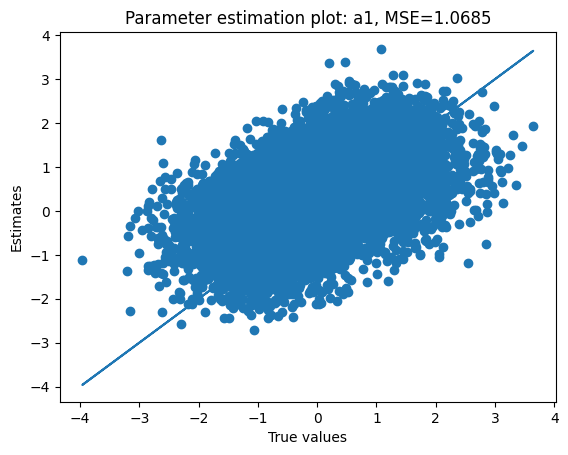

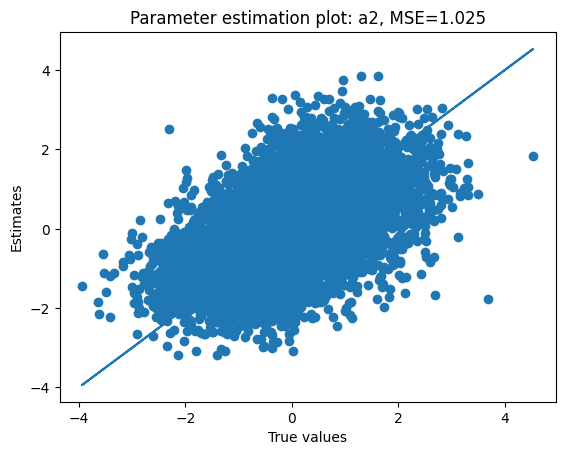

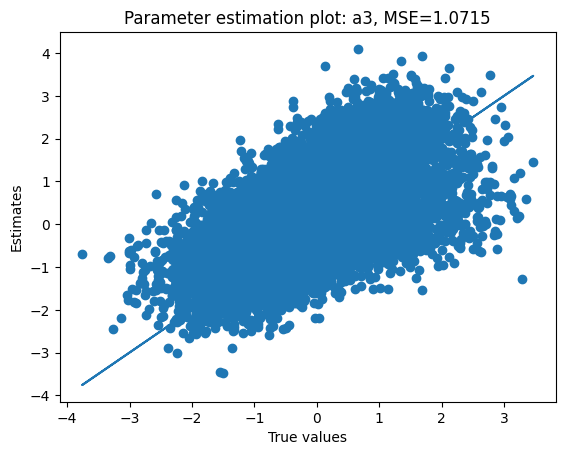

In [81]:
for dim in range(cfg['mirt_dim']):
    plt.figure()

    ai_est = theta_est[:,dim]
    ai_true = theta[:,dim]

    mse = MSE(ai_est, ai_true)
    plt.scatter(y=ai_est, x=ai_true)
    plt.plot(ai_true, ai_true)
    #for i, x in enumerate(ai_true):
    #    plt.text(ai_true[i], ai_est[i], i)
    plt.title(f'Parameter estimation plot: a{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')
    plt.show()